# Get multiple MIRE attributes for intersections

In [1]:
# import relevant types from our Python library
from dot.types.intersections import JunctionType, OSMJunction
from dot.types.osm import OSMNode

import osmnx

from dotenv import load_dotenv
load_dotenv()

# Counter efficiently collects statistics of distinct elements
from collections import Counter, defaultdict

In [2]:
# Configure osmnx to request OpenStreetMap data tags we will need
way_tags = [
    'bridge',
    'tunnel',
    'highway',
    'footway',
    'lanes',
    'maxspeed',
    'name',
    'tiger:name_base',
    'official_name',
    'alt_name',
    'oneway',
    'noexit',
    'abutters',
    'embedded_rails',
    'incline',
    'junction',
    'lit',
    'overtaking',
    'parking:condition',
    'parking:lane',
    'smoothness',
    'surface',
    'tactile_paving',
    'tracktype',
    'traffic_calming',
    'turn',
    'turn:lanes',
    'abutters',  # commercial / industrial / mixed / residential / retail etc. https://wiki.openstreetmap.org/wiki/Key:abutters
    'bicycle_road',
    'embedded_rails',
    'place',
    'railway',
    'bearing'
]
node_tags = [
    'ele',  # elevation
    'highway',  # turning circle, traffic signals, etc
    'ref',  # reference id?
    'barrier',
    'amenity',  # school, restaurant, parking, etc
    'emergency',  # firestation, hospital, etc
    'incline',
    'place',
    'name',
    'official_name',
    'alt_name',
]

osmnx.utils.config(
    use_cache=True,
    useful_tags_way=way_tags,
    useful_tags_node=node_tags,    
)

In [3]:
# Get OpenStreetMap data for Ithaca, NY
# Simplify resulting graph data to aggregate intersection information
G = osmnx.graph_from_place('Washington, DC', network_type='all', simplify=True)
G = osmnx.add_edge_bearings(G)

## Process nodes and adjacent edges to extract MIRE fields for intersections

In [4]:
from dot.osm import extract_intersection_type, extract_intersection_roadway_names, extract_intersection_angles

intersections = []

for n in G.nodes:
    # Intersections are represented as nodes, roadways as edges    
    if len(G.edges(n)) < 2:  # not an intersection
        continue

    osm_node = OSMNode(
        nodeid=str(G.nodes[n]['osmid']),
        latitude=G.nodes[n]['y'],
        longitude=G.nodes[n]['x']
    )

    # get intersection types, element 121
    intersection_type = extract_intersection_type(G, n)

    # get names of roadways and paths meeting at intersection
    names = extract_intersection_roadway_names(G, n)

    # intersecting angle 
    angle = extract_intersection_angles(G, n)

    intersections.append(
        OSMJunction(
            junction_type=intersection_type,
            num_legs=len(G.edges(n)),
            osm_node=osm_node,
            angle=angle,
            names=names
        )
    )

In [20]:
import random

idx = random.choice(range(len(intersections)))

idx = random.choice([i for i, x in enumerate(intersections) if x.junction_type & JunctionType.ROADWAY])

print(intersections[idx])

junction_type=<JunctionType.ROADWAY: 1> num_legs=3 geometry_type=None geometry=None angle=85.29999999999995 osm_node=OSMNode(nodeid='645963548', latitude=38.9053016, longitude=-77.0147494) names=['New Jersey Avenue Northwest', 'New York Avenue Northwest']


In [21]:
from dot.tiles import get_cropped_centered_img
img = get_cropped_centered_img(
    lat=intersections[idx].osm_node.latitude,
    lon=intersections[idx].osm_node.longitude,
    mapbox_token=os.getenv('MAPBOX_TOKEN'),
    zoom=18
)

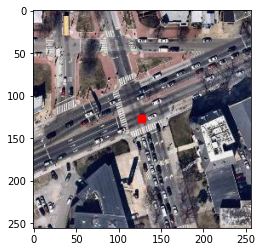

In [22]:
import matplotlib.pylab as plt
plt.imshow(img)